## Feasibility Study - Adjudication of MedDRA Trigger

### Machine Learning Classifier - Results

<table style="border:1px solid;">
    <thead style="border:1px solid;">
        <tr>
            <th> Classifier </th> 
            <th> BoW feature extraction method </th>
            <th> TF-IDF feature extraction method </th>
            <th> l2-norm BoW feature extraction method </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Naive Bayes</td>
            <td><b>Train: 69.41%, Test: 73.05%</b></td>
            <td>Train: 64.08%, Test: 65.25% </td>
            <td>Train: 67.42%, Test: 63.12% </td>
        </tr>
        <tr>
            <td> Multinomial Naive Bayes </td>
            <td>Train: 69.22%, Test: 51.06% </td>
            <td>Train: 69.52%, Test: 57.45% </td>
            <td>Train: 61.64%, Test: 47.52% </td>
        </tr>
        <tr>
            <td>Knearest Neighbors </td>
            <td>Train: 71.51%, Test: 51.06% </td>
            <td>Train: 9.65%, Test: 46.81%</td>
            <td>Train: 68.28%, Test: 46.1% </td>
        </tr>
        <tr>
            <td>Decision Tree </td>
            <td>Train: 71.51%, Test: 51.77% </td>
            <td>Train: 17.15%, Test: 51.77%</td>
            <td>Train: 71.51%, Test: 51.77 %</td>
        </tr>
        <tr>
            <td>Logistic Regression</td>
            <td>Train: 70.61%, Test: 47.52% </td>
            <td>Train: 43.21%, Test: 53.9% </td>
            <td>Train: 63.93%, Test: 47.52% </td>
        </tr>
    </tbody>
    </table>

In [2]:
# Imports

import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

%matplotlib inline



### Settings

In [19]:
split_percent = 0.05
seed = 10

### Import Data

In [3]:
def get_data(data_file_path):
    excel_file_obj = pd.ExcelFile(data_file_path)
    # print(excel_file_obj.sheet_names)
    # get all endpoints
    endpoint_df = excel_file_obj.parse("EPs ")
    endpoints = endpoint_df.loc[:, "Short Name"]
    frames = []
    for endpoint in endpoints:
        df = excel_file_obj.parse(endpoint+" PT")
        frames.append(df.loc[:,['Endpoint', 'MedDRA Preferred Term (PT)']])
    return pd.concat(frames)

def print_stats(df, year="2020"):
    print(f"No of rows in the dataset ({year}):{df.shape}")

data_file_path_2020 = os.path.join("../data","Master List of Preferred Term v21 2020_03_19.xlsx")
data_file_path_2019 = os.path.join("../data","Master List of Preferred Term v20 2019-10-23.xlsx")

df1 = get_data(data_file_path_2019)
df2 = get_data(data_file_path_2020)

print_stats(df1, os.path.basename(data_file_path_2019))
print_stats(df2,os.path.basename(data_file_path_2020))

No of rows in the dataset (Master List of Preferred Term v20 2019-10-23.xlsx):(1396, 2)
No of rows in the dataset (Master List of Preferred Term v21 2020_03_19.xlsx):(1409, 2)


In [4]:
## merge dataframes
frames = [df1, df2]
df = pd.concat(frames)
print("Number of rows in the merged dataset:",df.shape)


Number of rows in the merged dataset: (2805, 2)


### Data Pre-processing

In [11]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re

## Remove punctuation and lower casing
words = stopwords.words("english")
df['Processed-MedDRA Preferred Term (PT)'] = df['MedDRA Preferred Term (PT)'].apply(lambda x: " ".join([i for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c299342\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Feature Extraction

Feature extraction for text data can be performed in following ways:
- bag of words model
- TF-IDF vector

##### Bag of words

Bag of words representation of text data involves following steps:
- Tokenization - split the text into words
- Vocabulary building - collect all the words and number the words
- Encoding - count how often each word occurs in the vocabulary

In [117]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np


## 
count_vectorizer = CountVectorizer(stop_words = "english")
count_data = count_vectorizer.fit_transform(df['Processed-MedDRA Preferred Term (PT)'])

In [13]:
print("Vocabulary size:{}".format(len(count_vectorizer.vocabulary_)))
print("Vocabulary content:{}".format(count_vectorizer.vocabulary_))

Vocabulary size:728
Vocabulary content:{'accelerated': 8, 'idioventricular': 321, 'rhythm': 576, 'accessory': 11, 'cardiac': 111, 'pathway': 476, 'adams': 17, 'stokes': 617, 'syndrome': 639, 'agonal': 22, 'anomalous': 42, 'atrioventricular': 73, 'excitation': 254, 'arrhythmia': 51, 'neonatal': 427, 'supraventricular': 631, 'arrhythmogenic': 52, 'right': 577, 'ventricular': 708, 'dysplasia': 217, 'athletic': 71, 'heart': 291, 'atrial': 72, 'conduction': 162, 'time': 668, 'prolongation': 523, 'fibrillation': 262, 'flutter': 268, 'parasystole': 472, 'tachycardia': 644, 'block': 92, 'complete': 156, 'degree': 189, 'second': 587, 'shortened': 595, 'dissociation': 206, 'node': 437, 'dispersion': 202, 'baseline': 81, 'foetal': 269, 'rate': 545, 'variability': 698, 'disorder': 201, 'bifascicular': 87, 'bradyarrhythmia': 98, 'bradycardia': 99, 'brugada': 103, 'bundle': 104, 'branch': 101, 'bilateral': 88, 'left': 376, 'arrest': 50, 'death': 182, 'telemetry': 647, 'abnormal': 3, 'cardio': 112, '

In [14]:
## Plot most common words
def plot_most_common_words(count_data, count_vectorizer):
    words  = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    
    for t in count_data:
        total_counts+=t.toarray()[0]
        
    count_dict = zip(words, total_counts)
    count_dict = sorted(count_dict, key = lambda x: x[1], reverse = True)[0:20]
    
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    
    x_pos = np.arange(len(words))
    
    plt.figure(2, figsize = (10,5))
    plt.title("Most common words")
    
    plt.bar(x_pos, counts)
    plt.xticks(x_pos, words, rotation = 90)
    
    plt.xlabel("words")
    plt.ylabel("count")
    
    plt.show()


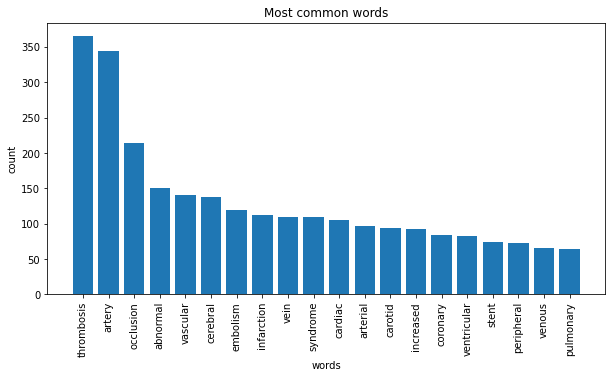

In [15]:
plot_most_common_words(count_data=count_data, count_vectorizer=count_vectorizer)

#### Machine Learning Classifier - BoW vector

In [36]:
## Split dataset
data = count_data.toarray()
labels = df["Endpoint"]

In [37]:
df.columns

Index(['Endpoint', 'MedDRA Preferred Term (PT)',
       'Processed-MedDRA Preferred Term (PT)'],
      dtype='object')

In [126]:
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=split_percent, random_state = seed)

In [127]:
print(f"No of training dataset:{X_train.shape}, No of test set: {X_test.shape}")

No of training dataset:(2664, 728), No of test set: (141, 728)


##### Dataset distribution

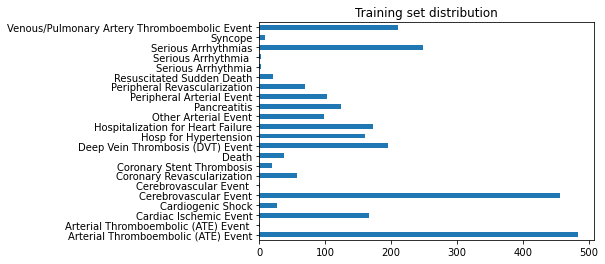

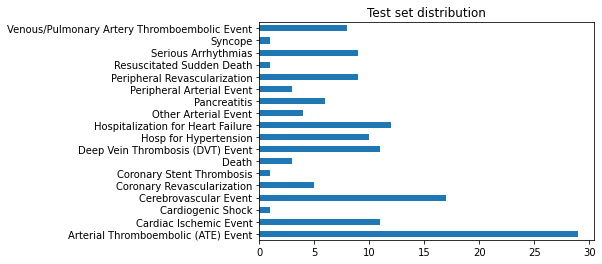

In [40]:
# Train set distribution
y_train.value_counts().sort_index().plot(kind="barh")
plt.title("Training set distribution")
plt.show()

# Test set distribution
y_test.value_counts().sort_index().plot(kind = "barh")
plt.title("Test set distribution")
plt.show()

##### ML Classifiers

- Logistic Regression
- Naive Bayes
- Multinomial Naive Bayes
- Knearest Neighbors
- Decision Tree 
- Voting Classifier - Ensemble Classifier

In [104]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

## knearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression 
from sklearn.linear_model import LogisticRegression

## Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB


"""
Common method to call various classifiers
"""
def classifier(x_tr, y_tr, x_test, y_test, classifier, descr=""):
    # function to call logistic regression
    m = classifier.fit(x_tr, y_tr)
    s = m.score(x_test, y_test)
    
    train_accuracy_score = m.score(X_train,y_train)
    print("Training accuracy:{}%".format(round(train_accuracy_score*100,2)))
    print ('Test score with', descr, 'features:', round(s*100,2),'%')
    return classifier
    

###### Naive Bayes

In [107]:
classifier_naive_bayes = GaussianNB()
classifier_naive_bayes = classifier(X_train, y_train, X_test, y_test, classifier_naive_bayes, "bow")


Training accuracy:69.41%
Test score with bow features: 73.05 %


###### Multinomial Naive Bayes

In [109]:
# multinomial naive bayes- does it makes sense?
classifier_mnb = MultinomialNB()
classifier_mnb = classifier(X_train, y_train, X_test, y_test, classifier_mnb, "bow")


Training accuracy:69.22%
Test score with bow features: 51.06 %


##### Knearest Neighbors

In [110]:
## 
classifier_knn = KNeighborsClassifier(n_neighbors = 5, weights = "distance", algorithm = "brute")
classifier_knn = classifier(X_train, y_train, X_test, y_test, classifier_knn, "bow")


Training accuracy:71.51%
Test score with bow features: 51.06 %


###### Decision Tree Classifier

In [112]:
classifier_dt = DecisionTreeClassifier(criterion="entropy", max_depth=None, splitter = "best", random_state = 55)
classifier_dt = classifier(X_train, y_train, X_test, y_test, classifier_dt, "bow")


Training accuracy:71.51%
Test score with bow features: 51.77 %


##### Logistic Regression

In [113]:
classifier_lr = LogisticRegression()
classifier_lr = classifier(X_train, y_train, X_test, y_test, classifier_lr, "bow")


Training accuracy:70.61%
Test score with bow features: 47.52 %


##### Voting Classifier

In [115]:
models = [('LogisticRegression', classifier_lr), 
          ('DecisionTree Classifier', classifier_dt),
          ('K-Nearest Neighbor',classifier_knn),
          ('Guassian Naive Bayes',classifier_naive_bayes),
          ('MultinomialNB',classifier_mnb)]

classifier_vc = VotingClassifier(voting='hard', estimators=models)
classifier_vc.fit(X_train, y_train)

# predicting the train data set results
y_pred_vc = classifier_vc.predict(X_test)

# confusion matrix
cm_vc = confusion_matrix(y_test, y_pred_vc)
print("Voting classifier  accuracy score on train set:{}".format(classifier_vc.score(X_train,y_train)*100))
print("Voting classifier  accuracy score on test set:{}".format(classifier_vc.score(X_test,y_test)*100))

Voting classifier  accuracy score on train set:71.43393393393393
Voting classifier  accuracy score on test set:51.77304964539007


#### Machine Learning Classifier - TF-IDF 

It stands for term frequency–inverse document frequency (TF-IDF). Instead of looking at the raw counts of each word in each document in a dataset, tf-idf looks at a normalized count where each word count is divided by the number of documents this word appear in. 

bow(W, d) = # number of times w appears in the document d;
tf-idf(w,d) = bow(w, d) * N/ (# documents in which word w appears)

N = total number of documents; N/ (# documents) - fraction also known as inverse document frequency.

<b>Tf-idf makes rare words more prominent and ignoring common words. </b>


In [128]:
tfidf_trfm = TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_train)
X_te_tfidf = tfidf_trfm.fit_transform(X_test)


X_tr_tfidf = X_tr_tfidf.toarray()
X_te_tfidf = X_te_tfidf.toarray()



###### Naive Bayes

In [132]:
classifier_naive_bayes = classifier(X_tr_tfidf.toarray(), y_train, X_te_tfidf.toarray(), y_test, classifier_naive_bayes,'tf-idf')


Training accuracy:64.08%
Test score with tf-idf features: 65.25 %


##### Multinomial Naive Bayes

In [133]:
classifier_mnb = classifier(X_tr_tfidf, y_train, X_te_tfidf, y_test, classifier_mnb, "tf-idf")


Training accuracy:69.52%
Test score with tf-idf features: 57.45 %


##### Knearest Neighbors

In [134]:
classifier_knn = classifier(X_tr_tfidf, y_train, X_te_tfidf, y_test, classifier_knn, "tf-idf")

Training accuracy:9.65%
Test score with tf-idf features: 46.81 %


###### Logistic Regression

In [137]:
classifier_lr = classifier(X_tr_tfidf, y_train, X_te_tfidf, y_test, classifier_lr, "tf-idf")


Training accuracy:43.21%
Test score with tf-idf features: 53.9 %


###### Decision Tree Classifier

In [136]:
classifier_dt = classifier(X_tr_tfidf, y_train, X_te_tfidf, y_test, classifier_dt, "tf-idf")


Training accuracy:17.15%
Test score with tf-idf features: 51.77 %


#### Machine Learning Classifier - L2 Normalized Bow

Normalized vector 

In [138]:
##
import sklearn.preprocessing as preproc

X_train_l2 = preproc.normalize(X_train, axis=0)
X_test_l2 = preproc.normalize(X_test, axis = 0)

In [145]:
## Naive Bayes
print("Naive Bayes")
classifier_naive_bayes = classifier(X_train_l2, y_train, X_test_l2, y_test, classifier_naive_bayes,'l2 norm')

Naive Bayes
Training accuracy:67.42%
Test score with l2 norm features: 63.12 %


In [146]:
# Multinomial Naive Bayes
print("Multinomial Naive Bayes")
classifier_mnb = classifier(X_train_l2, y_train, X_test_l2, y_test, classifier_mnb, "l2 norm")


Multinomial Naive Bayes
Training accuracy:61.64%
Test score with l2 norm features: 47.52 %


In [147]:
# knearest neighbor
print("Knearest Neighbor")
classifier_knn = classifier(X_train_l2, y_train, X_test_l2, y_test, classifier_knn, "l2 norm")

Knearest Neighbor
Training accuracy:68.28%
Test score with l2 norm features: 46.1 %


In [148]:
# logistic regression
print("Logistic Regression")
classifier_lr = classifier(X_train_l2, y_train, X_test_l2, y_test, classifier_lr, "l2 norm")

Logistic Regression
Training accuracy:63.93%
Test score with l2 norm features: 47.52 %


In [149]:
# decision tree
print("Decision Tree")
classifier_dt = classifier(X_train_l2, y_train, X_test_l2, y_test, classifier_dt, "l2 norm")

Decision Tree
Training accuracy:71.51%
Test score with l2 norm features: 51.77 %


### Clustering - LDA (Latent Dirichlet Allocation)

Finds groups of words that appear together

In [168]:
vectorizer = CountVectorizer(analyzer="word", min_df=10, stop_words="english", lowercase = True, token_pattern='[a-zA-Z0-9]{3,}')

# number of character >3, remove stop words, convert words to lowercase

vectorized_data = vectorizer.fit_transform(df['Processed-MedDRA Preferred Term (PT)'])


In [193]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" | ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# two parameters, number of topics, and number of words per topic
number_topics = 5
number_words = 1100

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda_output = lda.fit_transform(vectorized_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
administration | cestan | angina | amyloid | arterial | bilateral | bundle | atheroembolism | brachiocephalic | cardioversion | barrier | arteriosclerosis | cardiovascular | aortic | associated | abnormality | bifascicular | change | anginal | caval | assist | bacterial | cardiac | charcot | cirrhosis | alcoholic | brachial | atherosclerotic | angiotensin | amylase | calcification | capsule | bilirubin | accessory | application | brugada | cerebral | carasil | arrest | catheter | anomalous | cardiomegaly | aneurysmal | apparent | bendopnoea | brain | arteriogram | claudication | autoimmune | bronchial | ambulatory | accelerated | cardio | acute | alternation | circulation | atherectomy | alternans | cava | basilar | blindness | atrioventricular | attack | adams | aortogram | angioplasty | catheterisation | acuity | capillary | cardiothoracic | biliary | chronic | artery | block | abnormal | choroidal | cerebellar | central | absent | arteriotomy | catec

In [191]:
import pprint

print("Log Likelihood",lda.score(vectorized_data)) # higher the better
print("Perplexity: ", lda.perplexity(vectorized_data)) # lower the better
pprint.pprint(lda.get_params())

Log Likelihood -25187.16188141793
Perplexity:  100.53441129297161
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [161]:
### Topic's Keywords
import pandas as pd
df_topic_keywords = pd.DataFrame(lda.components_)
# 
df_topic_keywords.columns = count_vectorizer.get_feature_names()
df_topic_keywords.index = ["Topic: "+ str(i) for i in range(number_topics)]


df_topic_keywords.head()

,abdomen,abdominal,ablation,abnormal,abnormalities,abnormality,abscess,absent,accelerated,acceleration,...,wall,wallenberg,wandering,warning,wave,waves,wellens,white,withdrawal,wolff
Topic: 0,2.199948,0.200030,0.200018,16.948950,2.199975,0.200012,2.194486,6.199953,4.197656,0.200008,...,0.200008,0.214806,0.200020,0.200015,0.200012,0.200010,0.200032,0.203081,0.200020,0.203081
Topic: 1,0.200014,8.194797,0.200014,40.781471,0.200006,0.200009,0.200031,0.200012,0.202291,0.200006,...,0.200006,0.200060,0.200016,0.200010,0.200010,0.200008,2.199918,0.200017,4.199935,0.200017
Topic: 2,0.200015,10.205135,0.204503,28.068345,0.200008,0.200718,0.200035,0.200014,0.200020,0.200007,...,0.200007,0.200063,2.199937,0.200011,0.200011,0.200009,0.200019,0.200017,0.200018,0.200017
Topic: 3,0.200014,0.200023,2.195453,65.000789,0.200007,10.199255,0.205426,0.200012,0.200019,2.199975,...,2.199974,0.200062,0.200016,4.199957,18.199961,2.199967,0.200019,0.200017,0.200016,0.200017
Topic: 4,0.200009,0.200015,0.200012,0.200446,0.200004,0.200007,0.200022,0.200009,0.200013,0.200004,...,0.200005,2.185008,0.200012,0.200007,0.200007,0.200005,0.200012,2.196868,0.200011,2.196868


#### Visualizing clusters - TSNE plot

In [189]:
from sklearn.cluster import KMeans
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook 

clusters = KMeans(n_clusters = number_topics, random_state=100).fit_predict(lda_output)

topic_num = np.argmax(lda_output, axis=1)

## tsne
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne.fit_transform(lda_output)
 
output_notebook()
plot = figure(title='t-SNE clustering for {} LDA topics'.format(number_topics), plot_width = 900, plot_height = 700)
plot.scatter(x = tsne_lda[:,0], y = tsne_lda[:,1], color = mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2805 samples in 0.003s...
[t-SNE] Computed neighbors for 2805 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2805
[t-SNE] Computed conditional probabilities for sample 2000 / 2805
[t-SNE] Computed conditional probabilities for sample 2805 / 2805
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.575706
[t-SNE] KL divergence after 1000 iterations: -0.086528


Loading BokehJS ...